In [6]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors
import gsw # https://teos-10.github.io/GSW-Python/gsw_flat.html
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.optimize import curve_fit

import os

# IMPORT DATA

In [18]:
# Import all temp csv's from 1st deployment
temp2ma = pd.read_csv('Temperature/21444948-7.csv', header=1)
temp2mb = pd.read_csv('Temperature/21444948-7_823.csv', header=1)
temp2m = pd.merge(temp2ma, temp2mb, how='outer')
temp4m = pd.read_csv('Temperature/20235430-2_823.csv', header=1)
temp6m = pd.read_csv('Temperature/21444947-6.csv', header=1)
temp8m = pd.read_csv('Temperature/21444950-5_823.csv', header=1)
temp91m = pd.read_csv('Temperature/21444949-3_823.csv', header=1)
temp94m = pd.read_csv('Temperature/20235428-1_823.csv', header=1)
temp97m = pd.read_csv('Temperature/21444951-4_823.csv', header=1)

In [57]:
#4m, 2m, 6m, 8m, 9.1m, 9.4m, 9.7m
# Merge all seperate temperature depths (after some editing of columns names in excel)
# Has to be done in desired depth order to merge on inconsistent datetimes
temp_all = pd.merge(temp_all, temp97m, how='outer', on='Date Time')

In [ ]:
# Export 1st deployment
temp_all = pd.to_csv('Temperature/temp_all.csv', index = False)
temp_all

In [3]:
# Do the same thing with 2nd deployment csv's
temp2m_b = pd.read_csv('Temperature/21444948-7_909.csv', header=1)
temp4m_b = pd.read_csv('Temperature/20235430-2_909.csv', header=1)
temp6m_b = pd.read_csv('Temperature/21444947-6_909.csv', header=1)
temp8m_b = pd.read_csv('Temperature/21444950-5_909.csv', header=1)
temp91m_b = pd.read_csv('Temperature/21444949-3_909.csv', header=1)
temp94m_b = pd.read_csv('Temperature/20235428-1_909.csv', header=1)
temp97m_b = pd.read_csv('Temperature/21444951-4_909.csv', header=1)

In [54]:
temp_b = pd.merge(temp_b, temp97m_b, how='outer', on='Date Time', suffixes=('_9.4m','_9.7m'))

In [57]:
# For merge of 1st and 2nd deployment, column names need to be identical
temp_b = temp_b.drop(columns=['#_2m', '#_4m', '#_6m', '#_8m', '#_9.1m', '#_9.4m', '#' ])
temp_b = tempb.rename(columns={'Temp_2m':'2m', 'Temp_4m':'4m', 'Temp_6m':'6m', 'Temp_8m':'8m', 'Temp_9.1m':'9.1m', 'Temp_9.4m':'9.4m', 'Temp_9.7m':'9.7m', })

In [17]:
# Export merged csv for 2nd deployment
temp_b.to_csv('Temperature/temp_b.csv', index = False)

### For reimporting both datasets

In [ ]:
temp1 = pd.read_csv('Temperature/temp_all.csv')

temp2 = pd.read_csv('Temperature/temp_b.csv')

In [35]:
# Merge both datasets chronologically
temp = temp1.append(temp2)

In [196]:
# Convert datetime to pandas datetime class for easier plotting
temp['Date Time'] = pd.to_datetime(temp['Date Time'])

# QUALITY CONTROL/ORGANIZATION

Deployment and retrieval temperatures skew the data to higher than normal values and must be removed

In [156]:
# Remove rows: 0-78, 504-578(2m only), 35640-35647(2m only), 35734-47518( 6m only) ,47466-47516, 70412-76584

# At these rows, only 2m and 6m data is affected, and so they are converted to NaN's rather than deleting the good data from the other depths
# This is done first since removing the rows also affects the dataframe index
temp.iloc[35640:35724, 1] = 'NaN'
temp.iloc[35732:47519, 3] = 'NaN'

# All depths of data are skewed at these points, so these entire rows are removed
temp = temp.drop(range(0,579,1), axis=0)
temp = temp.drop(range(47466,47530,1), axis=0)
temp = temp.drop(range(70404,76584,1), axis=0)

In [ ]:
# Check that entire dataset is consistent
plt.figure(figsize = (20, 10))
plt.plot(temp['Date Time'], temp['2m'], '-r')
plt.plot(temp['Date Time'], temp['4m'], 'darkorange')
plt.plot(temp['Date Time'], temp['6m'], '-b')
plt.plot(temp['Date Time'], temp['8m'], '-g')
plt.plot(temp['Date Time'], temp['9.1m'], '-c')
plt.plot(temp['Date Time'], temp['9.4m'], '-y')
plt.plot(temp['Date Time'], temp['9.7m'], '-k')
plt.xlim([19194.8,19243.6])
plt.ylim([10, 17])

In [195]:
# Export to a final, merged and quality controlled csv file
temp.to_csv('Temperature/temp_qc.csv', index = False)

### Converting the dataframe to xarray dataset

For future analysis with Richardson number and temperature change with depth over time, it will be more convenient for data to be in matrix form

In [2]:
temp = pd.read_csv('Temperature/temp_qc.csv')
time = pd.to_datetime(temp['Date Time'])
time

0       2022-07-21 22:39:00
1       2022-07-21 22:40:00
2       2022-07-21 22:41:00
3       2022-07-21 22:42:00
4       2022-07-21 22:43:00
                ...        
69756   2022-09-08 10:29:00
69757   2022-09-08 10:30:00
69758   2022-09-08 10:31:00
69759   2022-09-08 10:32:00
69760   2022-09-08 10:33:00
Name: Date Time, Length: 69761, dtype: datetime64[ns]

In [3]:
# Create two dimensional temperature matrix
temp_m = temp.iloc[:,1:] # Take only the temperature data since datetime is a coordinate now
temp_m = temp_m.to_numpy() # Convert columns of data into numpy matrix
temp_m = temp_m.T # Transpose matrix so that it's in more visualizable form (depth on y-axis, time on x-axis)

# create coords of dataset
dep = np.array((2, 4, 6, 8, 9.25, 9.5, 9.75)) #Depth of loggers from the surface

mab = np.array((8.75, 6.75, 4.75, 2.75, 1.5, 1.25, 1)) #Height of loggers from the seafloor (same coordinates as adcp)

# put data into a dataset
temp_ds = xr.Dataset(
    data_vars=dict(
        Temperature = (["bindist", "time"], temp_m),
    ),
    coords=dict(
        depth=(["depth"], dep),
        bindist = (["bindist"], mab),
        time=(["time"], time),
    ),
    attrs=dict(description="Temperature of water column over time"),
)

In [4]:
temp_ds

<xarray.Dataset>
Dimensions:      (bindist: 7, time: 69761, depth: 7)
Coordinates:
  * depth        (depth) float64 2.0 4.0 6.0 8.0 9.25 9.5 9.75
  * bindist      (bindist) float64 8.75 6.75 4.75 2.75 1.5 1.25 1.0
  * time         (time) datetime64[ns] 2022-07-21T22:39:00 ... 2022-09-08T10:...
Data variables:
    Temperature  (bindist, time) float64 nan nan nan nan ... 12.32 12.32 12.34
Attributes:
    description:  Temperature of water column over time

In [5]:
temp_ds.to_netcdf('Temperature/temp_qc.nc')

In [4]:
# Temperature data
temp = xr.open_dataset('Temperature/temp_final.nc')

# SeaPHOX data
spx = xr.open_dataset('SeaPHOX/seaphox.nc')

In [5]:
temp

<xarray.Dataset>
Dimensions:        (bindist: 7, time: 69761, depth: 7)
Coordinates:
  * depth          (depth) float64 2.0 4.0 6.0 8.0 9.25 9.5 9.75
  * bindist        (bindist) float64 8.75 6.75 4.75 2.75 1.5 1.25 1.0
  * time           (time) datetime64[ns] 2022-07-21T22:39:00 ... 2022-09-08T1...
Data variables:
    Temperature    (bindist, time) float64 ...
    Rho            (bindist, time) float64 ...
    TemperatureDA  (time) float64 ...
    RhoDA          (time) float64 ...
Attributes: (12/13)
    description:           Temperature of water column over time
    Description:           Temperature and density profiles of Stillwater Cove
    Creator:               Logan Grady
    Contact information:   loganagrady@gmail.com
    Instrument:            HOBO Temperature Logger Pro V2
    Sampling rate:         1Min
    ...                    ...
    Latitude:              36.56196
    Longitude:             -121.94176
    Deployment:            2022-07-21T22:39:00.000000000
    Retrieval:             2022-09-08T10:33:00.000000000
    Depths from surface:   ['2m', '4m', '6m', '8m', '9.25m', '9.5m', '9.75m']
    Height from seafloor:  ['8.75m', '6.75m', '4.75m', '2.75m', '1.5m', '1.25...

# Repairing the data

In [3]:
#Account for missing temperature as best as possible
temp = xr.open_dataset('Temperature/temp_final.nc')
adv2 = xr.open_dataset('ADV/adv2_final2.nc')

#Use the adv as bottom temperature
vecDS = adv2.copy(deep=True)

#Resample adv temperature to be sample frequency
advTemp = vecDS.Temperature.resample(time_sen='1Min').mean()

#Isolate bottom temperature where the gap is
gapTemp = temp.where(temp.Temperature.isel(bindist = 1).isnull() == True).dropna(dim='time',how='all')
gapTimes = gapTemp.time

#Create indices for the gap
gapIDX = np.where(temp.time.isin(gapTimes))[0]

#Isolate temperature from the ADV where the gap in the temperature loggers is
missingTemp = advTemp.where(advTemp.time_sen.isin(gapTimes)).dropna(dim='time_sen',how='all')

#Interpolate the temperature over the same time dimension as the loggers
missingTempInterp = missingTemp.interp(time_sen = gapTimes.values,method='linear').values

#Identify the surface temperature that was present during the logger replacement period
Tsurf = gapTemp.Temperature[0].values

#Initialize new numpy array with original temperature values
T_arr = temp.Temperature.values

#Replace the surface and bottom temperatures
T_arr[0][gapIDX[0]:gapIDX[-1]+1] = Tsurf
T_arr[6][gapIDX[0]:gapIDX[-1]+1] = missingTempInterp

#Add the 'fixed' temperature array back to the temperature dataset
temp['Temperature'] = (['bindist','time'],T_arr,{'Units':'Celsius','Description':'Temperature recorded by the individual loggers',
                                                'Notes':'times 42864:46887 have been supplemented with ADV temperature'})

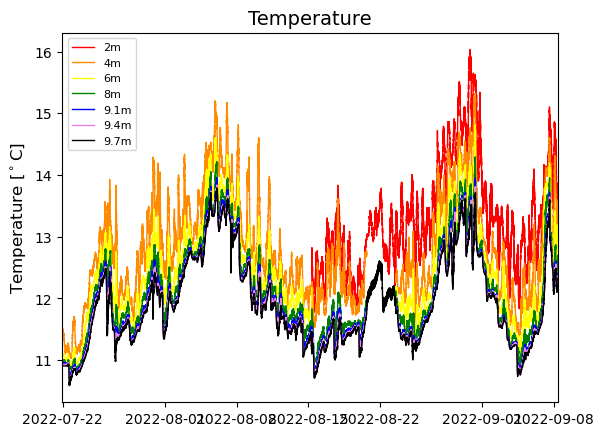

In [4]:
#Check the results
fig,axs=plt.subplots()
axs.set_title('Temperature', size=14) 
axs.set_prop_cycle(c = ['red','darkorange','yellow','green','blue','violet','black'])
axs.plot(temp.time, temp.Temperature.T, lw = 1)
axs.set_ylabel(r'Temperature [$^\circ$C]', fontsize=12)
#axs[0].tick_params(axis = 'x', labelrotation = 15, labelsize = 8)
axs.margins(x=0)
axs.legend(['2m', '4m','6m','8m','9.1m', '9.4m', '9.7m'], loc = 'upper left', fontsize=8)

# SeaPHOX data

In [ ]:
# Creates a string for the filepath for ADCP data
path = 'SeaPHOX/'
files = os.listdir(path)

# Creates a list of filenames where the first filename in the '21m' directory is omitted
file_len = list(range(1, len(files)))

# Creates dataframe 'df1' with the first raw data table in the directory
# The first file is the first month(s) of data, and serves as a starting point to merge the future data with
df1 = pd.read_csv((str(path) + str(files[0])), skiprows = 4, parse_dates=[[0,1]])

# A for loop which reads the raw data files in chronological order then creates a new dataframe called 'df2'
# df1 is appended with df2, and the loop continues until all data files are appended to df1
for val in file_len:
    df2 = pd.read_csv((str(path) + str(files[val])), skiprows = 4, parse_dates=[[0,1]])
    df1 = df1.append(df2, ignore_index=True)

# With the new, completely merged dataframe, each column is properly renamed, a redundant column known as 'unknown' is removed, and all
# data that exceeds a depth of 22 (the max depth of the adcp) is removed
df1 = df1.rename(columns = {'Date_UTC_Time_UTC':'datetime'})
df1.datetime = pd.to_datetime(df1.datetime)

ds = xr.Dataset(coords={'time': df1['datetime'].values})
for var in df1.columns[1:]:
    vardata = np.float64(df1[var].values)
    ds[var] = (['time'],vardata)
ds['Depth'].attrs['Units'] = 'Feet'
ds['Temperature'].attrs['Units'] = 'Celsius (C)'
ds['OxyUM'].attrs['Units'] = 'MicroMol (UM)'
ds['OxymgL'].attrs['Units'] = 'Milligrams per Liter (mg/L)'
ds['Sal'].attrs['Units'] = 'PSU'
ds['Sal'].attrs['Description'] = 'Practical salinity converted from the conductivity recorded by the instrument.'
ds['QC'].attrs['Flag values'] = '1: Pass, 2: Not evaluated, 3: Suspect, 4: Fail'
ds['QC'].attrs['Description'] = 'Flag score following QARTOD protocol.'
ds.attrs['Title'] = 'StillwaterData'
ds.attrs['Original creator'] = 'Emily Donham'
ds.attrs['Creator contact information'] = 'edonham@ucsb.edu'
ds.attrs['Site'] = 'Stillwater Cove (SWC)'
ds.attrs['Sensor'] = 'SAT333 (SeaPHOX)'
ds.attrs['Sample frequency'] = '15 minutes'

ds

# Determining density stratification
- Kelp-forest mooring does not have conductivity/salinity data, only in-situ temperature
- Use multi-year seapHOx data to evaluate whether temperature or salinity plays a larger role in influencing density

In [ ]:
# Calculating in-situ density
ds['Pressure'] = (['time'], ds.Depth / 3.281) # Converts the depth recorded from the dataset to pressure
ds['Pressure'].attrs['Units'] = 'dBar'

# Salinity is PSU, but GSW requires absolute salinity for calculating CT and rho
ds['SA'] = (['time'], gsw.conversions.SA_from_SP(ds.Sal, ds.Pressure, -121.941750, 36.561972)) # Uses pressure, psu, and lat/lon of SWC to calculate absolute salinity
ds['SA'].attrs['Units'] = 'Absolute salinity (g/kg)'
ds['SA'].attrs['Description'] = 'Absolute salinity calculated from in-situ practical salinity using gsw.conversion.SA_from_SP().'

ds['CT'] = (['time'], gsw.conversions.CT_from_t(ds.SA, ds.Temperature, ds.Pressure)) # Use SA and pressure to calculate conservative temperature
ds['CT'].attrs['Units'] = 'Celsuis (C)'
ds['CT'].attrs['Description'] = 'Conservative temperature (ITS-90) calculated from in-situ temperature using gsw.conversion.CT_from_t().'

rho, alpha, beta = gsw.density.rho_alpha_beta(ds.SA, ds.CT, ds.Pressure) 
ds['Density'] = (['time'], rho)
ds['Density'].attrs['Units'] = 'kg/m3'
ds['Density'].attrs['Description'] = 'In-situ density calculated from salinity, conservative temperature, and pressure using gsw.density.rho_alpha_beta().'
ds['Alpha'] = (['time'], alpha)
ds['Alpha'].attrs['Units'] = '1/K'
ds['Alpha'].attrs['Description'] = 'Thermal expansion coefficient with respect to conservative temperature.'
ds['Beta'] = (['time'], beta)
ds['Beta'].attrs['Units'] = 'kg/g'
ds['Beta'].attrs['Description'] = 'Saline contraction coefficient at constant conservative temperature.'

In [3]:
#ds.to_netcdf('SeaPHOX/seaphox.nc')

In [2]:
spx = xr.open_dataset('SeaPHOX/seaphox.nc')
temp = xr.open_dataset('Temperature/temp_final.nc')

In [6]:
spx

<xarray.Dataset>
Dimensions:      (time: 103515)
Coordinates:
  * time         (time) datetime64[ns] 2016-02-25T10:30:00 ... 2020-10-15T13:...
Data variables: (12/15)
    Depth        (time) float64 ...
    Temperature  (time) float64 ...
    pH_int       (time) float64 ...
    pH_extT      (time) float64 ...
    pH_extF      (time) float64 ...
    OxyUM        (time) float64 ...
    ...           ...
    Pressure     (time) float64 ...
    SA           (time) float64 ...
    CT           (time) float64 ...
    Density      (time) float64 ...
    Alpha        (time) float64 ...
    Beta         (time) float64 ...
Attributes:
    Title:                        StillwaterData
    Original creator:             Emily Donham
    Creator contact information:  edonham@ucsb.edu
    Site:                         Stillwater Cove (SWC)
    Sensor:                       SAT333 (SeaPHOX)
    Sample frequency:             15 minutes

In [3]:
# seapHOx data: spx

# Create subset of quality controlled data from summer months
spxqc = spx.where(spx.QC < 2)
spxs = spxqc.isel(time=spxqc.time.dt.month.isin([6, 7, 8, 9])) # Flagged seaphox data during only summer months (June-August)
spxs = spxs.where((spxs.Density > 24.5)).dropna(dim = 'time', how="any") # Filter out data that shows anomalously fresh waters

spxs1 = spxs.isel(time=spxs.time.dt.year.isin([2016, 2017, 2018, 2019]))
spxs1 = spxs1.where(spxs1.SA > (spxs1.SA.mean() - spxs1.SA.std()),drop=True)
spxs2 = spxs.isel(time=spxs.time.dt.year.isin([2020]))
spxs2 = spxs2.where(spxs2.SA > (spxs2.SA.mean() - spxs2.SA.std()),drop=True)

C:\Users\LoganAGrady\anaconda3\lib\site-packages\xarray\core\accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
C:\Users\LoganAGrady\anaconda3\lib\site-packages\xarray\core\accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
C:\Users\LoganAGrady\anaconda3\lib\site-packages\xarray\core\accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


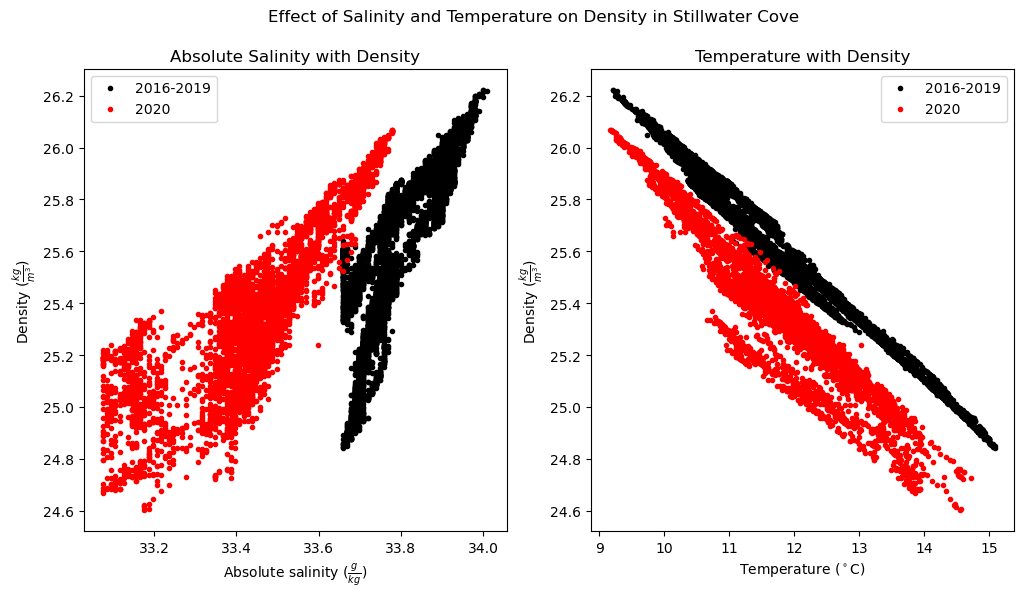

In [4]:
fig, axs = plt.subplots(1,2,figsize = (12,6))

fig.suptitle('Effect of Salinity and Temperature on Density in Stillwater Cove')

axs[0].set_title('Absolute Salinity with Density')
axs[0].plot(spxs1.SA, spxs1.Density, '.k', label = '2016-2019')
axs[0].plot(spxs2.SA, spxs2.Density, '.r', label = '2020')
axs[0].set_xlabel(r'Absolute salinity ($\frac{g}{kg}$)')
axs[0].set_ylabel(r'Density ($\frac{kg}{m^{3}}$)')
axs[0].legend(loc='upper left')

axs[1].set_title('Temperature with Density')
axs[1].plot(spxs1.Temperature, spxs1.Density, '.k', label = '2016-2019')
axs[1].plot(spxs2.Temperature, spxs2.Density, '.r', label = '2020')
axs[1].set_xlabel(r'Temperature ($^\circ$C)')
axs[1].set_ylabel(r'Density ($\frac{kg}{m^{3}}$)')
axs[1].legend(loc='upper right')

In [37]:
# Salinity vs. Density
print(stats.linregress(spxs1.SA, spxs1.Density))
stats.linregress(spxs2.SA, spxs2.Density)

LinregressResult(slope=2.880975942006048, intercept=-71.74308482780376, rvalue=0.8498618111467738, pvalue=0.0, stderr=0.020371130981490095, intercept_stderr=0.688450310795772)


LinregressResult(slope=1.5481953854842703, intercept=-26.415261874866196, rvalue=0.8439872607636505, pvalue=0.0, stderr=0.01463294071437748, intercept_stderr=0.48936494425196814)

In [38]:
# Conservative temperature vs. Density
print(stats.linregress(spxs1.Temperature, spxs1.Density))
stats.linregress(spxs2.Temperature, spxs2.Density)

LinregressResult(slope=-0.23017362375381784, intercept=28.31653104284002, rvalue=-0.9919762357879855, pvalue=0.0, stderr=0.00033449839384841793, intercept_stderr=0.003943170928859051)


LinregressResult(slope=-0.2569368159913885, intercept=28.374036568397017, rvalue=-0.946892066346276, pvalue=0.0, stderr=0.001297655005689351, intercept_stderr=0.015291428901168636)

### Fitting linear regression to pre 2020 data
- Data from 2020 is significantly skewed from 2016-19 data
- Seperate regressions should be used in order to generate a linear model for estimating density

In [26]:
spxs.Density

<xarray.DataArray 'Density' (time: 12947)>
array([25.54249566, 25.55186718, 25.55747817, ..., 24.5573703 ,
       24.53169058, 24.54902431])
Coordinates:
  * time     (time) datetime64[ns] 2016-06-01 ... 2020-09-24T14:00:00
Attributes:
    Units:        kg/m3
    Description:  In-situ density calculated from salinity, conservative temp...

In [31]:
# Relevant variables and the means of the variables to serve as the constants
P = spxs1.Pressure
SA = spxs1.SA
SA_mean = np.mean(SA)
CT = spxs1.CT
CT_mean = np.mean(CT)

rho_constant_SA = gsw.rho(SA_mean, CT, P) # Constant absolute salinity with changing temperature
rho_constant_CT = gsw.rho(SA, CT_mean, P) # Constant conservative temperature with changing SA


CT_density = np.array(rho_constant_SA).reshape(-1,1)
SA_density = np.array(rho_constant_CT).reshape(-1,1)
real_density = np.array(spxs1.Density).reshape(-1,1) # The in-situ density calculated from all in-situ variables
SA_reg = stats.linregress(rho_constant_CT, spxs1.Density)
CT_reg = stats.linregress(rho_constant_SA, spxs1.Density)

print(str('SA score: '), SA_reg.rvalue, str('CT score: '), str(CT_reg.rvalue))

SA score:  0.8915835038333365 CT score:  0.9899232106318254


In [18]:
# METHOD 1: Use linear regression between in-situ temperature and in-situ density to estimate density
temperature = np.array(spxs1.Temperature).reshape(-1,1) # in-situ temperature
density = np.array(spxs1.Density).reshape(-1,1) # in-situ density

temp_density_reg = LinearRegression().fit(temperature, density) # linear regression fit between the two variables

temp_density_est_spxs1 = (temperature * temp_density_reg.coef_[0]) + temp_density_reg.intercept_[0] # The density estimates calculated using the linear equation of 'reg1'

reg1_spxs1 = LinearRegression().fit(temp_density_est_spxs1, density) # Fit a linear regression between the estimated density and in-situ density

# METHOD 2: Use constant salinity to estimate CT and then use both to estimate density
CT_est = gsw.conversions.CT_from_t(SA_mean, spxs1.Temperature, P) # Estimate CT using mean value of SA from seapHOx data
rho_from_CT_est = np.array(gsw.rho(SA_mean, CT_est, P)).reshape(-1,1) # Estimate density using model CT and mean value of SA

reg2_spxs1 = LinearRegression().fit(rho_from_CT_est, density)

print(str('Method 1 R2: '), reg1_spxs1.score(temp_density_est_spxs1, density), str('Method 2 R2: '), reg2_spxs1.score(rho_from_CT_est, density))

Method 1 R2:  0.9826634772533815 Method 2 R2:  0.9797287083481567


### 2020 data

In [19]:
# Relevant variables and the means of the variables to serve as the constants
P = spxs2.Pressure
SA = spxs2.SA
SA_mean = np.mean(SA)
CT = spxs2.CT
CT_mean = np.mean(CT)

rho_constant_SA = gsw.rho(SA_mean, CT, P) # Constant absolute salinity with changing temperature
rho_constant_CT = gsw.rho(SA, CT_mean, P) # Constant conservative temperature with changing SA


CT_density = np.array(rho_constant_SA).reshape(-1,1)
SA_density = np.array(rho_constant_CT).reshape(-1,1)
real_density = np.array(spxs2.Density).reshape(-1,1) # The in-situ density calculated from all in-situ variables
SA_reg = LinearRegression().fit(SA_density, real_density)
CT_reg = LinearRegression().fit(CT_density, real_density)

print(str('SA score: '), SA_reg.score(SA_density, real_density), str('CT score: '), CT_reg.score(CT_density, real_density))

SA score:  0.7187244811606799 CT score:  0.8839004951076143


In [20]:
# METHOD 1: Use linear regression between in-situ temperature and in-situ density to estimate density
temperature = np.array(spxs2.Temperature).reshape(-1,1) # in-situ temperature
density = np.array(spxs2.Density).reshape(-1,1) # in-situ density

temp_density_reg = LinearRegression().fit(temperature, density) # linear regression fit between the two variables

temp_density_est_spxs2 = (temperature * temp_density_reg.coef_[0]) + temp_density_reg.intercept_[0] # The density estimates calculated using the linear equation of 'reg1'

reg1_spxs2 = LinearRegression().fit(temp_density_est_spxs2, density) # Fit a linear regression between the estimated density and in-situ density

# METHOD 2: Use constant salinity to estimate CT and then use both to estimate density
CT_est = gsw.conversions.CT_from_t(SA_mean, spxs2.Temperature, P) # Estimate CT using mean value of SA from seapHOx data
rho_from_CT_est = np.array(gsw.rho(SA_mean, CT_est, P)).reshape(-1,1) # Estimate density using model CT and mean value of SA

reg2_spxs2 = LinearRegression().fit(rho_from_CT_est, density)

print(str('Method 1 R2: '), reg1_spxs2.score(temp_density_est_spxs2, density), str('Method 2 R2: '), reg2_spxs2.score(rho_from_CT_est, density))

Method 1 R2:  0.8885994100989449 Method 2 R2:  0.8823575774725761


### Comparing and combining the two regressions
- Temperature is better predictor than salinity for both datasets
- Method 1 (linear regression between in-situ temperature and density) yields best fit for estimating density
- Average the two linear regression equations using M1 and use in-situ temperature from kelp forest mooring to estimate density profiles

In [49]:
t1 = np.array(spxs1.Temperature).reshape(-1,1) # in-situ temperature
d1 = np.array(spxs1.Density).reshape(-1,1) # in-situ density
t2 = np.array(spxs2.Temperature).reshape(-1,1)
d2 = np.array(spxs2.Density).reshape(-1,1)

reg1 = stats.linregress(spxs1.Temperature, spxs1.Density) # linear regression fit between the two variables
reg2 = stats.linregress(spxs2.Temperature, spxs2.Density)
regBoth = stats.linregress(spxs.Temperature,spxs.Density)

# Average components of both regressions
rho1 = (reg1.slope*temp.Temperature) + reg1.intercept + 1000
rho2 = (reg2.slope*temp.Temperature) + reg2.intercept + 1000

# Apply the linear regression equation to kelp-forest temperature
temp['Rho'] = (rho1+rho2)/2 # The density estimates calculated using the linear equation of 'reg1'

In [50]:
temp['TemperatureDA'] = temp.Temperature.mean(dim = 'bindist')
temp['RhoDA'] = temp.Rho.mean(dim = 'bindist')

In [51]:
temp

<xarray.Dataset>
Dimensions:        (bindist: 7, time: 69761, depth: 7)
Coordinates:
  * depth          (depth) float64 2.0 4.0 6.0 8.0 9.25 9.5 9.75
  * bindist        (bindist) float64 8.75 6.75 4.75 2.75 1.5 1.25 1.0
  * time           (time) datetime64[ns] 2022-07-21T22:39:00 ... 2022-09-08T1...
Data variables:
    Temperature    (bindist, time) float64 nan nan nan nan ... 12.32 12.32 12.34
    Rho            (bindist, time) float64 nan nan nan ... 1.025e+03 1.025e+03
    TemperatureDA  (time) float64 11.0 11.0 11.0 11.01 ... 12.62 12.64 12.67
    RhoDA          (time) float64 1.026e+03 1.026e+03 ... 1.025e+03 1.025e+03
Attributes: (12/13)
    description:           Temperature of water column over time
    Description:           Temperature and density profiles of Stillwater Cove
    Creator:               Logan Grady
    Contact information:   loganagrady@gmail.com
    Instrument:            HOBO Temperature Logger Pro V2
    Sampling rate:         1Min
    ...                    ...
    Latitude:              36.56196
    Longitude:             -121.94176
    Deployment:            2022-07-21T22:39:00.000000000
    Retrieval:             2022-09-08T10:33:00.000000000
    Depths from surface:   ['2m', '4m', '6m', '8m', '9.25m', '9.5m', '9.75m']
    Height from seafloor:  ['8.75m', '6.75m', '4.75m', '2.75m', '1.5m', '1.25...

In [52]:
#Add attributes and relevant metadata
temp['depth'].attrs['Units'] = 'm'
temp['depth'].attrs['Description'] = 'Depth of the individual loggers from the surface'
temp['bindist'].attrs['Units'] = 'm'
temp['bindist'].attrs['Description'] = 'Height of the individual loggers from the seafloor'
temp['Temperature'].attrs['Units'] = 'Celsius'
temp['Temperature'].attrs['Description'] = 'Temperature recorded by the individual loggers'
temp['Rho'].attrs['Units'] = r'$\frac{kg}{m^{3}}$'
temp['Rho'].attrs['Description'] = 'Density estimates from linear regression models of temperature in Stillwater Cove'
temp['TemperatureDA'].attrs['Units'] = 'Celsius'
temp['TemperatureDA'].attrs['Description'] = 'Depth-averaged temperature'
temp['RhoDA'].attrs['Units'] = r'$\frac{kg}{m^{3}}$'
temp['RhoDA'].attrs['Description'] = 'Depth-averaged density'

temp.attrs['Description'] = 'Temperature and density profiles of Stillwater Cove'
temp.attrs['Creator'] = 'Logan Grady'
temp.attrs['Contact information'] = 'loganagrady@gmail.com'
temp.attrs['Instrument'] = 'HOBO Temperature Logger Pro V2'
temp.attrs['Sampling rate'] = '1Min'
temp.attrs['Project site'] = 'Stillwater Cove, Carmel CA'
temp.attrs['Latitude'] = 36.56196
temp.attrs['Longitude'] = -121.94176
temp.attrs['Deployment'] = '2022-07-21T22:39:00.000000000'
temp.attrs['Retrieval'] = '2022-09-08T10:33:00.000000000'
temp.attrs['Depths from surface'] = ['2m','4m','6m','8m','9.25m','9.5m','9.75m']
temp.attrs['Height from seafloor'] = ['8.75m','6.75m','4.75m','2.75m','1.5m','1.25m','1m']

In [53]:
#Export dataset
temp.to_netcdf('Temperature/temp_final2.nc')

In [8]:
temp = xr.open_dataset('Temperature/temp_final2.nc')

In [54]:
#Calculate a hypothetical density using the mean salinity from the seaphox
test = gsw.density.rho_t_exact(33.38, temp.Temperature, temp.bindist)

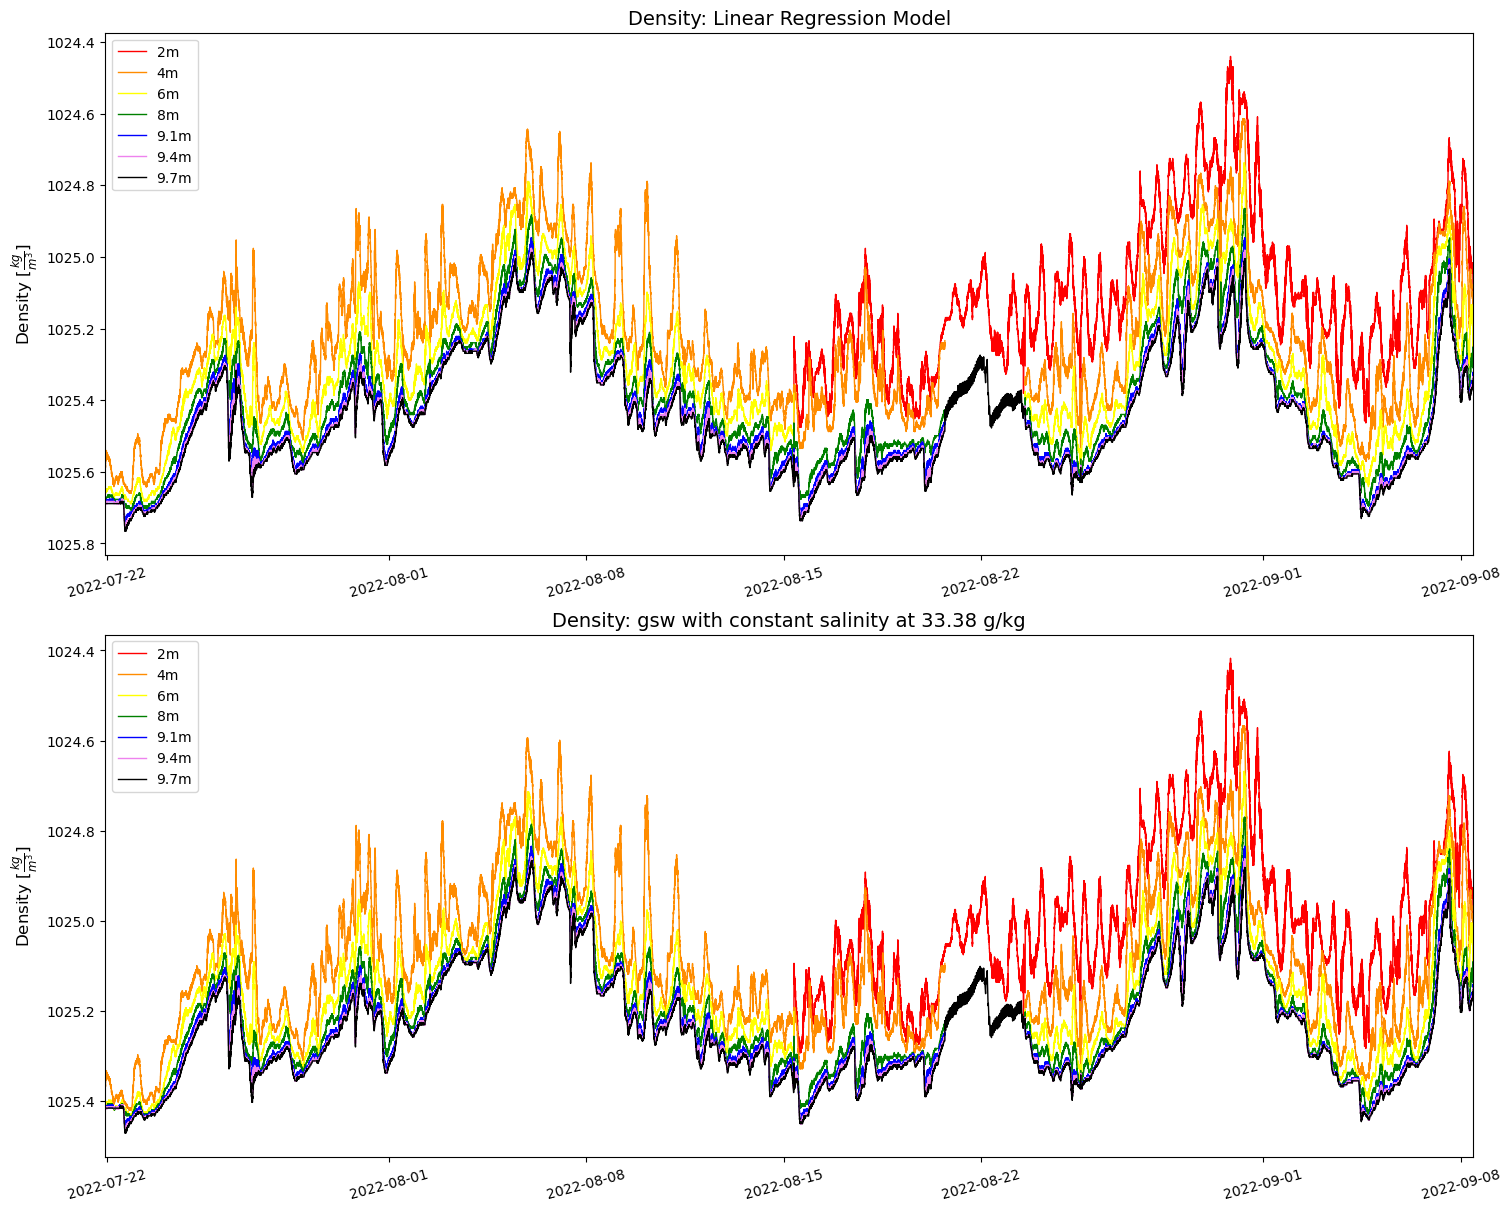

In [55]:
#Compare the hypothetical to the estimated density from the linear regression model
fig, axs = plt.subplots(2,1, constrained_layout=True, figsize = (15,12))
axs[0].set_title('Density: Linear Regression Model', size = 14)
axs[0].set_prop_cycle(c = ['red','darkorange','yellow','green','blue','violet','black'])
axs[0].plot(temp.time, temp.Rho.T, lw = 1)
axs[0].set_ylabel(r"Density [$\frac{kg}{m^{3}}$]", fontsize=12)
axs[0].invert_yaxis()
axs[0].tick_params(axis = 'x', labelrotation = 15)
axs[0].margins(x=.00)
axs[0].legend(['2m', '4m','6m','8m','9.1m', '9.4m', '9.7m'], fontsize=10)

axs[1].set_title('Density: gsw with constant salinity at 33.38 g/kg', size = 14)
axs[1].set_prop_cycle(c = ['red','darkorange','yellow','green','blue','violet','black'])
axs[1].plot(test.time, test.T, lw = 1)
axs[1].set_ylabel(r"Density [$\frac{kg}{m^{3}}$]", fontsize=12)
axs[1].invert_yaxis()
axs[1].tick_params(axis = 'x', labelrotation = 15)
axs[1].margins(x=.00)
axs[1].legend(['2m', '4m','6m','8m','9.1m', '9.4m', '9.7m'], fontsize=10)


### Takeaways
- Little to no difference between the two methods
- Density appears to follow temperature very closely, as shown by R2 values from method 1
- Not many visible periods of intense mixing, even during cooling events
    - Water column remains fairly stratified at all times
    - Does kelp forest stabilize the water column?
    - Based on the stratification, I expect low turbulence
### Potential questions
- Does kelp forest stabilize the water column?
    - At what stipe bundle density might this stabilization occur?
    - Is SWC always stratified like this?
- How does the stratification change with the stipe bundle density/radii?
- High dissipation rate as kelp filters faster currents via wake?
- Does adv proximity to stipe bundles matter?